# Deep Learning Classification

Maria Leonor Zamora

***
***

## Import Libraries

In [1]:

from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# This creates the data folder -> raw and processed
import sys
sys.path.append("script")
from sub import subMNIST 

Files already downloaded
3000
750


In [3]:
import sys
sys.path.append("DL_A1_LargeNet")
import image_transformations

## Load Pickle Data

In [4]:

trainset_imoprt = pickle.load(open("A1_deep_data/train_labeled.p", "rb"))
trainset_unlabel_imoprt = pickle.load(open("A1_deep_data/train_unlabeled_1.p", "rb"))
validset_import = pickle.load(open("A1_deep_data/validation.p", "rb"))


In [250]:

BATCH_NUM_SIZE = 64
MOMENTUM_VALUE = 0.9

trainset_imoprt_numpy = trainset_imoprt.train_data.numpy()
trainset_labels_imoprt_numpy = trainset_imoprt.train_labels.numpy()

trainset_unlabel_imoprt_numpy = trainset_unlabel_imoprt.train_data.numpy()

validset_import_numpy =validset_import.test_data.numpy()
validset_labels_import_numpy = validset_import.test_labels.numpy()

print ( trainset_imoprt.train_data.numpy().shape )
print ( trainset_unlabel_imoprt.train_data.numpy().shape )
print ( validset_import.test_data.numpy().shape )


(3000, 28, 28)
(47000, 28, 28)
(10000, 28, 28)


# Pre-process 

In [6]:

def range_scale():
    # 0.8 to 1.2
    return 0.8

def range_rotation():
    # -pi/6 to pi/6
    return 45.

def random_translation():
    xrand = np.random
    if xrand <= 0.5: return True
    else: return False


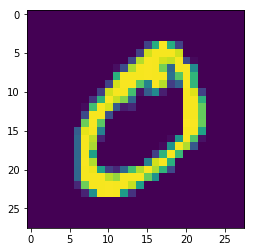

In [7]:
dataiter = iter( trainset_imoprt_numpy[0:1] )
images = dataiter.next()
plt.imshow(images)
#plt.imshow(images, cmap='gray')
#print(' '.join('%5s'%train_label_numpy[j]for j in range(BATCH_NUM_SIZE)))


# TRAIN - TRANSFORMATION
trainset_scaled = np.array([image_transformations.scale(x,range_scale()) for x in trainset_imoprt_numpy ])
trainset_rotated = np.array([image_transformations.rotation(x,range_rotation()) for x in trainset_scaled ])
trainset_translated = np.array([image_transformations.translation(x,0.5,horizontal=random_translation()) for x in trainset_rotated ])

trainset_loader_preprocessed = torch.from_numpy(trainset_translated)
trainset_imoprt.train_data = trainset_loader_preprocessed.clone()
trainset_imoprt.train_labels = torch.from_numpy(trainset_labels_imoprt_numpy).clone()


# UNLABELED TRAIN - TRANSFORMATION
trainset_unlabel_scaled = np.array([image_transformations.scale(x,range_scale()) for x in trainset_unlabel_imoprt_numpy ])
trainset_unlabel_rotated = np.array([image_transformations.rotation(x,range_rotation()) for x in trainset_unlabel_scaled])
trainset_unlabel_translated = np.array([image_transformations.translation(x,0.5,horizontal=random_translation()) for x in trainset_unlabel_rotated])

trainset_unlabel_loader_preprocessed = torch.from_numpy(trainset_unlabel_translated)
trainset_unlabel_imoprt.train_data = trainset_unlabel_loader_preprocessed.clone()
trainset_unlabel_imoprt.train_labels = torch.from_numpy(np.repeat(-1,
                                                trainset_unlabel_imoprt.train_data.size()[0])).clone()

# TEST - TRANSFORMATION
validset_scaled = np.array([image_transformations.scale(x,range_scale()) for x in validset_import_numpy ])
validset_rotated = np.array([image_transformations.rotation(x,range_rotation()) for x in trainset_scaled ])
validset_translated = np.array([image_transformations.translation(x,0.5,horizontal=random_translation()) for x in trainset_rotated ])

validset_loader_preprocessed = torch.from_numpy(validset_translated)
validset_import.train_data = validset_loader_preprocessed.clone()
validset_import.train_labels = torch.from_numpy(validset_labels_import_numpy).clone()



dataiter = iter( trainset_translated[0:1] )
images = dataiter.next()
plt.imshow(images)
#plt.imshow(images, cmap='gray')
#print(' '.join('%5s'%train_label_numpy[j]for j in range(BATCH_NUM_SIZE)))

# Train Model 

21-layer convolutional network (ConvNet) , in which the inputs are 32-by-32 images and all convolutional layers are 3-by-3 and fully padded. ll pooling layers are max-pooling, and ReLUs

In [245]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d has stride=1 default where pixel = ‘stride’
        # Conv1d sounds, conv2d images, conv3d videos
        # input size (N,Cin,H,W)(N,Cin,H,W) and output (N,Cout,Hout,Wout)(N,Cout,Hout,Wout)
        # out(Ni,Coutj)=bias(Coutj)+∑Cin−1k=0weight(Coutj,k)⋆input(Ni,k)
        
        TOTAL_KERNEL = 3
        padding=TOTAL_PADDING = 3
        channel1 = 10
        channel2 = 10
        channel3 = 10
        channel4 = 10
        self.last_channel = channel4
        
        self.conv1 = nn.Conv2d(1, channel1, kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv2 = nn.Conv2d(channel1,channel1,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv3 = nn.Conv2d(channel1,channel1,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        
        self.conv5 = nn.Conv2d(channel1,channel2, kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv6 = nn.Conv2d(channel2,channel2,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv7 = nn.Conv2d(channel2,channel2,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv8 = nn.Conv2d(channel2,channel2,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        
        self.conv10 = nn.Conv2d(channel2,channel3, kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv11 = nn.Conv2d(channel3,channel3,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv12 = nn.Conv2d(channel3,channel3,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv13 = nn.Conv2d(channel3,channel3,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        
        self.conv15 = nn.Conv2d(channel3,channel3, kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv16 = nn.Conv2d(channel3,channel3,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv17 = nn.Conv2d(channel3,channel3,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv18 = nn.Conv2d(channel3,channel3,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        
        self.conv20 = nn.Conv2d(channel3,channel4, kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv21 = nn.Conv2d(channel4,channel4,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv22 = nn.Conv2d(channel4,channel4,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        self.conv23 = nn.Conv2d(channel4,channel4,kernel_size=TOTAL_KERNEL, padding=TOTAL_PADDING)
        
        self.conv_drop_a = nn.Dropout2d()
        
        self.fc1 = nn.Linear(channel4*16*16, 50)    # LAST OUTPUT LAYER x LAST SIZE x LAST SIZE :  AFTER LAST CONV2D
        self.fc2 = nn.Linear(50, 10)
        

    def forward(self, x):
        #print ("original size = ",x.size())
        #x = self.conv1(x)
        #print ("conv size = ", x.size())
        #x = F.max_pool2d(self.conv1(x), 2)
        #print ("max pool size = ", x.size())
        #x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print ("relu size 1", x.size())
        
        x = self.conv3( self.conv2( self.conv1(x) ) )
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv8( self.conv7( self.conv6( self.conv5(x) ) ) )
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv13( self.conv12( self.conv11( self.conv10(x) ) ) )
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv18( self.conv17( self.conv16( self.conv15(x) ) ) )
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv23( self.conv22( self.conv21( self.conv20(x) ) ) )
        x = F.relu(F.max_pool2d(x, 2))
        #print (x.size())
        
        #x = F.relu(F.max_pool2d(self.conv_drop_a(self.conv18(x)), 2))
        
        x = x.view(-1, self.last_channel*16*16)
        #print ("before drop", x.size())
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #print ("after drop", x.size())
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        #print ("after drop", x.size())
        
        return F.log_softmax(x)

model = Net()


In [246]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=MOMENTUM_VALUE)


In [247]:
# CPU only training
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    

In [248]:

train_loader = torch.utils.data.DataLoader(trainset_imoprt, batch_size=BATCH_NUM_SIZE, shuffle=True)
#train_unlabel_loader = torch.utils.data.DataLoader(trainset_unlabel_imoprt, batch_size=BATCH_NUM_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=BATCH_NUM_SIZE, shuffle=True)


In [251]:

for epoch in range(1, 3):
    train(epoch)
    test(epoch, valid_loader)
    

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.303890
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.298603
Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.307538
Train Epoch: 1 [1920/3000 (64%)]	Loss: 2.300804
Train Epoch: 1 [2560/3000 (85%)]	Loss: 2.306649

Test set: Average loss: 2.3027, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 2.300977
Train Epoch: 2 [640/3000 (21%)]	Loss: 2.306214
Train Epoch: 2 [1280/3000 (43%)]	Loss: 2.301062
Train Epoch: 2 [1920/3000 (64%)]	Loss: 2.307528
Train Epoch: 2 [2560/3000 (85%)]	Loss: 2.299569

Test set: Average loss: 2.3027, Accuracy: 1000/10000 (10%)

